# IV - Modélisation par Machine Learning

## 1. Motivations de l'approche par apprentissage automatique

Le modèle de Lee–Carter, bien qu'établi comme référence dans la modélisation 
de la mortalité, repose sur une structure paramétrique relativement rigide. 
Il suppose une décomposition logarithmique des taux de mortalité selon une 
tendance moyenne par âge (αₓ), une composante temporelle (κₜ) et un facteur 
d'interaction par âge (βₓ), en imposant en outre des contraintes d'identifiabilité.

Cependant, cette modélisation linéaire présente plusieurs **limites** :
- Elle ne permet pas de capturer des **effets non linéaires complexes** entre 
  l'âge et le temps
- Elle suppose une forme unique d'évolution temporelle pour tous les âges, ce 
  qui peut ne pas refléter les dynamiques réelles
- Elle ne tire pas pleinement parti des capacités prédictives des données 
  historiques lorsqu'elles sont nombreuses

Dans ce contexte, l'émergence des **méthodes d'apprentissage automatique** 
(Machine Learning) offre une alternative souple et performante. Ces modèles 
ont démontré leur efficacité dans divers domaines prédictifs, notamment en 
santé, finance, ou assurance, grâce à leur capacité à :
- Modéliser des **relations complexes** entre les variables explicatives 
  (âge, année, sexe, etc.) et la variable cible (taux de mortalité)
- S'adapter aux structures de données massives et hétérogènes
- Fournir des **prédictions robustes**, y compris en présence d'effets 
  d'interaction ou de non-linéarité

Contrairement aux modèles paramétriques classiques, les algorithmes 
d'apprentissage automatique sont dits **data-driven** : ils apprennent 
directement la structure des données sans imposer de forme fonctionnelle 
a priori. Cela en fait des candidats pertinents pour la prévision de la 
mortalité dans un cadre exploratoire, où l'objectif est de maximiser la 
précision prédictive.

Dans la suite de cette section, nous mettons en œuvre plusieurs modèles de 
Machine Learning notamment **Random Forest**, **Gradient Boosting (XGBoost)**, 
**SVM** et **MLP** sur la base de mortalité française construite précédemment. 
Nous comparerons leurs performances en termes d'erreur absolue moyenne (MAE), 
racine de l'erreur quadratique moyenne (RMSE) et erreur relative moyenne (MAPE).

## 2. Modélisation par Random Forest
### 2.1 Imports et préparation de l'environnement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2.2 Vérification de la base de données

Nous commençons par vérifier que la base `dfm` (construite dans les sections 
précédentes) est correctement chargée et contient les variables nécessaires.

In [3]:
dfm = pd.read_csv("base_mortality.csv")

In [12]:
print("\n Vérification de la base de données")
print(f"   - Dimensions : {dfm.shape}")
print(f"   - Période : {dfm['Year'].min()} - {dfm['Year'].max()}")
print(f"   - Âges : {dfm['Age'].min()} - {dfm['Age'].max()}")
print(f"   - Variables cibles : m_F, m_M, m_Tot")


 Vérification de la base de données
   - Dimensions : (20592, 11)
   - Période : 1816 - 2023
   - Âges : 0 - 98
   - Variables cibles : m_F, m_M, m_Tot


## 2.3 Découpage temporel des données

Pour respecter la causalité dans une série temporelle, les données sont séparées selon l'année :

- **Train (1816–1972)** : apprentissage initial  
- **Validation (2011–2016)** : tuning des hyperparamètres  
- **Test (2017–2023)** : évaluation finale du pouvoir prédictif

Les variables explicatives utilisées sont :

- l'âge (`Age`)
- l'année (`Year`)

Les cibles sont :

- `m_F` : mortalité femmes  
- `m_M` : mortalité hommes  
- `m_Tot` : mortalité totale  

In [4]:
print("\n Découpage temporel des données")
print("   - TRAIN : 1816-2010 (entraînement initial)")
print("   - CV    : 2011-2016 (tuning hyperparamètres)")
print("   - TEST  : 2017-2023 (évaluation finale)")

train = dfm[dfm['Year'] <= 2010].copy()
cv = dfm[(dfm['Year'] > 2010) & (dfm['Year'] <= 2016)].copy()
test = dfm[dfm['Year'] > 2016].copy()

print(f"\n   Tailles :")
print(f"   - Train : {len(train)} obs ({len(train)/len(dfm)*100:.1f}%)")
print(f"   - CV    : {len(cv)} obs ({len(cv)/len(dfm)*100:.1f}%)")
print(f"   - Test  : {len(test)} obs ({len(test)/len(dfm)*100:.1f}%)")

features = ['Year', 'Age']
targets = {'Femmes': 'm_F', 'Hommes': 'm_M', 'Total': 'm_Tot'}

X_train = train[features]
X_cv = cv[features]
X_test = test[features]

y_train = {name: train[col] for name, col in targets.items()}
y_cv = {name: cv[col] for name, col in targets.items()}
y_test = {name: test[col] for name, col in targets.items()}


 Découpage temporel des données
   - TRAIN : 1816-2010 (entraînement initial)
   - CV    : 2011-2016 (tuning hyperparamètres)
   - TEST  : 2017-2023 (évaluation finale)

   Tailles :
   - Train : 19305 obs (93.8%)
   - CV    : 594 obs (2.9%)
   - Test  : 693 obs (3.4%)


## 2.4 Modèle de base (paramètres par défaut)

Nous entraînons une Random Forest standard avec :

- 100 arbres
- profondeur non limitée
- bootstrap activé
- sélection aléatoire des features

L’objectif est d’obtenir une première évaluation brute du pouvoir prédictif du modèle.


In [5]:
# Paramètres par défaut
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Résultats pour chaque cible
results_baseline = {}

for name, target_col in targets.items():
    print(f"\n   Modèle pour : {name} ({target_col})")
    
    start_time = time.time()
    rf_baseline.fit(X_train, y_train[name])
    train_time = time.time() - start_time
    
    # Prédictions
    y_pred_train = rf_baseline.predict(X_train)
    y_pred_cv = rf_baseline.predict(X_cv)
    y_pred_test = rf_baseline.predict(X_test)
    
    # Métriques
    metrics = {
        'train': {
            'MSE': mean_squared_error(y_train[name], y_pred_train),
            'MAE': mean_absolute_error(y_train[name], y_pred_train),
            'R2': r2_score(y_train[name], y_pred_train)
        },
        'cv': {
            'MSE': mean_squared_error(y_cv[name], y_pred_cv),
            'MAE': mean_absolute_error(y_cv[name], y_pred_cv),
            'R2': r2_score(y_cv[name], y_pred_cv)
        },
        'test': {
            'MSE': mean_squared_error(y_test[name], y_pred_test),
            'MAE': mean_absolute_error(y_test[name], y_pred_test),
            'R2': r2_score(y_test[name], y_pred_test)
        },
        'train_time': train_time
    }
    
    results_baseline[name] = metrics
    
    print(f"      Temps d'entraînement : {train_time:.2f}s")
    print(f"      TRAIN - MSE: {metrics['train']['MSE']:.6f} | MAE: {metrics['train']['MAE']:.6f} | R²: {metrics['train']['R2']:.4f}")
    print(f"      CV    - MSE: {metrics['cv']['MSE']:.6f} | MAE: {metrics['cv']['MAE']:.6f} | R²: {metrics['cv']['R2']:.4f}")
    print(f"      TEST  - MSE: {metrics['test']['MSE']:.6f} | MAE: {metrics['test']['MAE']:.6f} | R²: {metrics['test']['R2']:.4f}")


   Modèle pour : Femmes (m_F)
      Temps d'entraînement : 0.38s
      TRAIN - MSE: 0.000020 | MAE: 0.001448 | R²: 0.9985
      CV    - MSE: 0.000013 | MAE: 0.001402 | R²: 0.9968
      TEST  - MSE: 0.000015 | MAE: 0.001740 | R²: 0.9961

   Modèle pour : Hommes (m_M)
      Temps d'entraînement : 0.36s
      TRAIN - MSE: 0.000037 | MAE: 0.001825 | R²: 0.9977
      CV    - MSE: 0.000024 | MAE: 0.002209 | R²: 0.9966
      TEST  - MSE: 0.000044 | MAE: 0.003268 | R²: 0.9937

   Modèle pour : Total (m_Tot)
      Temps d'entraînement : 0.36s
      TRAIN - MSE: 0.000020 | MAE: 0.001460 | R²: 0.9986
      CV    - MSE: 0.000013 | MAE: 0.001577 | R²: 0.9970
      TEST  - MSE: 0.000017 | MAE: 0.002016 | R²: 0.9963


## 2.5 Optimisation des hyperparamètres (validation 2011–2016)

Une grille relativement large est explorée :

- `n_estimators` : 100, 200, 500  
- `max_depth` : 10, 20, 30, None  
- `min_samples_split` : 2, 5, 10  
- `min_samples_leaf` : 1, 2, 4  

Soit **108 combinaisons par sexe**, explorées en grid-search manuel.

Le critère d’optimisation est le **MSE sur l’échantillon de validation (2011–2016)**.


In [6]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"\n   Grille : {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])} combinaisons")

best_params = {}

for name, target_col in targets.items():
    print(f"\n   Tuning pour : {name}")
    
    best_score = float('inf')
    best_param = None
    
    for n_est in param_grid['n_estimators']:
        for max_d in param_grid['max_depth']:
            for min_split in param_grid['min_samples_split']:
                for min_leaf in param_grid['min_samples_leaf']:
                    
                    rf = RandomForestRegressor(
                        n_estimators=n_est, max_depth=max_d,
                        min_samples_split=min_split, min_samples_leaf=min_leaf,
                        random_state=42, n_jobs=-1, verbose=0
                    )
                    
                    rf.fit(X_train, y_train[name])
                    pred_cv = rf.predict(X_cv)
                    mse_cv = mean_squared_error(y_cv[name], pred_cv)
                    
                    if mse_cv < best_score:
                        best_score = mse_cv
                        best_param = {
                            'n_estimators': n_est, 'max_depth': max_d,
                            'min_samples_split': min_split, 'min_samples_leaf': min_leaf
                        }
    
    best_params[name] = best_param
    print(f"    Meilleurs paramètres : {best_param}")

    


   Grille : 108 combinaisons

   Tuning pour : Femmes
    Meilleurs paramètres : {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}

   Tuning pour : Hommes
    Meilleurs paramètres : {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}

   Tuning pour : Total
    Meilleurs paramètres : {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}


## 2.6 Modèle final entraîné sur (Train + CV)

La totalité des années 1816–2016 est utilisée pour réentraîner les modèles avec les hyperparamètres optimaux.  
L’évaluation est réalisée sur la période 2017–2023.


In [7]:
train_full = pd.concat([train, cv], axis=0)
X_train_full = train_full[features]
y_train_full = {name: train_full[col] for name, col in targets.items()}

final_models = {}
predictions = {}

for name, target_col in targets.items():
    print(f"\n   Modèle pour : {name}")
    
    rf_final = RandomForestRegressor(**best_params[name], random_state=42, n_jobs=-1, verbose=0)
    
    start = time.time()
    rf_final.fit(X_train_full, y_train_full[name])
    train_time = time.time() - start
    
    final_models[name] = rf_final
    
    # Prédictions sur test
    y_pred_test = rf_final.predict(X_test)
    predictions[name] = y_pred_test
    
    print(f"      Temps : {train_time:.2f}s")
    print(f"      R² test : {r2_score(y_test[name], y_pred_test):.4f}")


   Modèle pour : Femmes
      Temps : 0.37s
      R² test : 0.9987

   Modèle pour : Hommes
      Temps : 0.37s
      R² test : 0.9970

   Modèle pour : Total
      Temps : 1.33s
      R² test : 0.9984


## 2.7 Evaluation des performances du modèle

Nous présentons ici les métriques de performance du modèle sur chaque population :

    - MAE (Mean Absolute Error) : erreur absolue moyenne

    - RMSE (Root Mean Squared Error) : racine de l’erreur quadratique moyenne

    - MAPE (%) (Mean Absolute Percentage Error) : erreur moyenne en pourcentage, en ignorant les valeurs nulles

Ces métriques permettent de quantifier la précision des prédictions du modèle pour chaque population et d’avoir un aperçu global de sa performance.

In [8]:
metrics_table = []

for name in targets.keys():
    y_true = y_test[name]
    y_pred = predictions[name]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAPE : éviter division par zéro
    mask_nonzero = y_true > 0
    mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100
    
    metrics_table.append({
        'Population': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

df_metrics = pd.DataFrame(metrics_table)
print("\n" + df_metrics.to_string(index=False))


Population      MAE     RMSE  MAPE (%)
    Femmes 0.000828 0.002263  8.589033
    Hommes 0.001614 0.004600  7.391211
     Total 0.000995 0.002701  6.204993


## 2.8 Importance des variables

Pour chaque population, nous visualisons :

- La heatmap des résidus (Observé − Prédit) selon l’âge et l’année,
ce qui permet de détecter où le modèle sous-estime ou surestime les taux de mortalité.
- Le scatter plot Observé vs Prédit, où la diagonale parfaite montre une prédiction idéale.

Ces visualisations permettent d’évaluer la précision du modèle et l’existence éventuelle de biais selon l’âge ou l’année.


   Génération Figure pour : Femmes


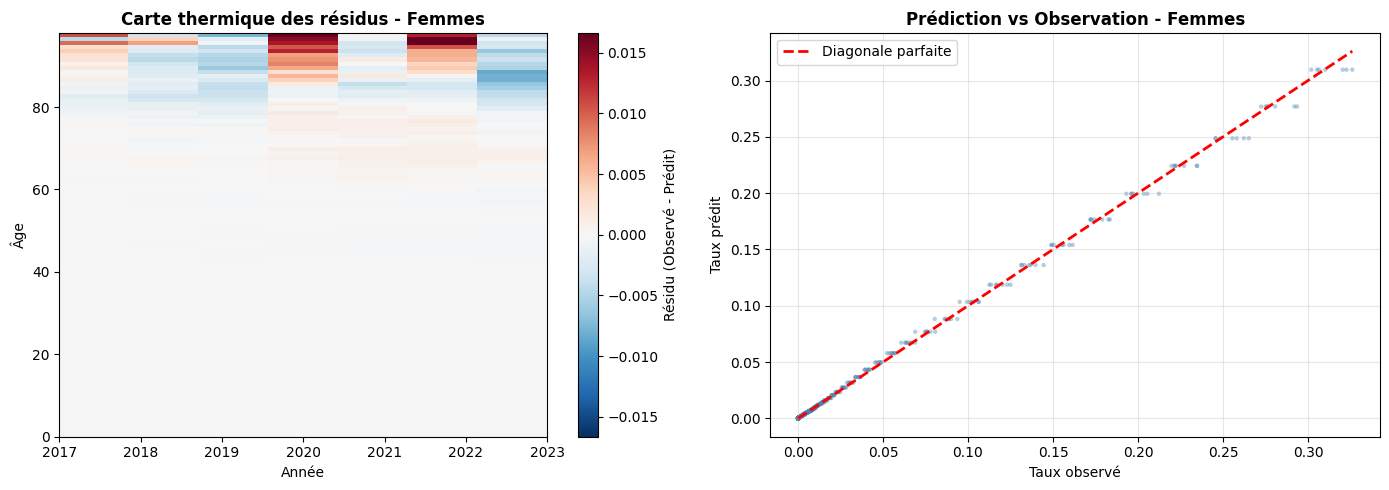


   Génération Figure pour : Hommes


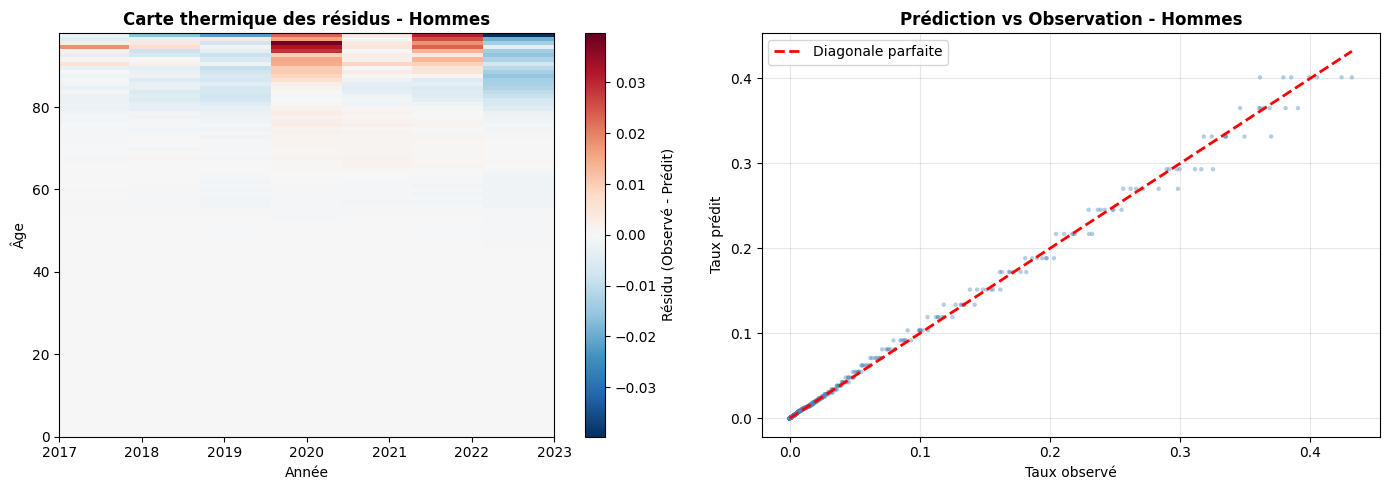


   Génération Figure pour : Total


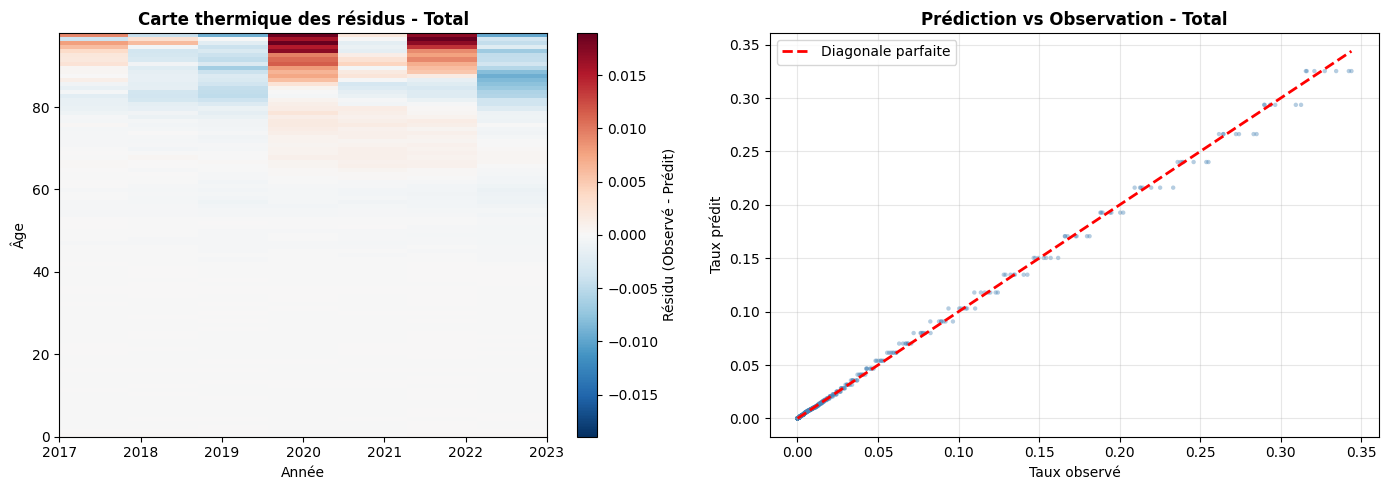

In [9]:
# Ajouter les prédictions au dataframe test
test_viz = test.copy()
for name in targets.keys():
    test_viz[f'pred_{targets[name]}'] = predictions[name]
    test_viz[f'resid_{targets[name]}'] = test_viz[targets[name]] - test_viz[f'pred_{targets[name]}']

# Pour chaque population, créer Figure avec heatmap + scatter
for name, target_col in targets.items():
    print(f"\n   Génération Figure pour : {name}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- HEATMAP DES RÉSIDUS (gauche) ---
    pivot_resid = test_viz.pivot_table(
        index='Age', columns='Year', 
        values=f'resid_{target_col}', 
        aggfunc='mean'
    )
    
    # Normalisation centrée sur 0 pour diverging colormap
    vmax = np.abs(pivot_resid.values).max()
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    im = axes[0].imshow(
        pivot_resid.values, 
        aspect='auto', origin='lower',
        extent=[pivot_resid.columns.min(), pivot_resid.columns.max(),
                pivot_resid.index.min(), pivot_resid.index.max()],
        cmap='RdBu_r', norm=norm, interpolation='nearest'
    )
    
    axes[0].set_title(f'Carte thermique des résidus - {name}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Année', fontsize=10)
    axes[0].set_ylabel('Âge', fontsize=10)
    fig.colorbar(im, ax=axes[0], label='Résidu (Observé - Prédit)')
    
    # --- SCATTER PLOT (droite) ---
    y_true = test_viz[target_col]
    y_pred = test_viz[f'pred_{target_col}']
    
    axes[1].scatter(y_true, y_pred, alpha=0.4, s=10, color='steelblue', edgecolors='none')
    
    # Diagonale parfaite
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Diagonale parfaite')
    
    axes[1].set_title(f'Prédiction vs Observation - {name}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Taux observé', fontsize=10)
    axes[1].set_ylabel('Taux prédit', fontsize=10)
    axes[1].legend(loc='upper left')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 2.9 Importance des variables La Random Forest fournit une mesure de l’importance relative de chaque feature : 

- l’âge est largement dominant ; 
- l’année joue un rôle secondaire mais non nul. 

 Cela reflète la forte variabilité de la mortalité selon l’âge.

In [13]:
importance_table = []

for name in targets.keys():
    importances = final_models[name].feature_importances_
    
    importance_table.append({
        'Population': name,
        'Age (IncNodePurity)': importances[1],  # Age est en position 1
        'Année (IncNodePurity)': importances[0]  # Year est en position 0
    })

df_importance = pd.DataFrame(importance_table)
print("\n" + df_importance.to_string(index=False))

print("\n" + "="*70)
print("FIN DE LA MODÉLISATION PAR RANDOM FOREST")
print("="*70)


Population  Age (IncNodePurity)  Année (IncNodePurity)
    Femmes             0.919700               0.080300
    Hommes             0.932908               0.067092
     Total             0.924707               0.075293

FIN DE LA MODÉLISATION PAR RANDOM FOREST


# 2.10 Analyse des résidus par âge

Cette section calcule et visualise les résidus moyens du modèle en fonction de l’âge pour chaque population.

 - Nous regroupons les données par âge et calculons la moyenne des résidus pour chaque groupe.

 - Pour chaque population, nous traçons une courbe des résidus moyens par âge, avec une ligne horizontale à zéro pour référence.

 - Ces visualisations permettent d’identifier les tendances générales des erreurs du modèle selon l’âge et de faciliter l’interprétation des performances du modèle sur différentes tranches d’âge.

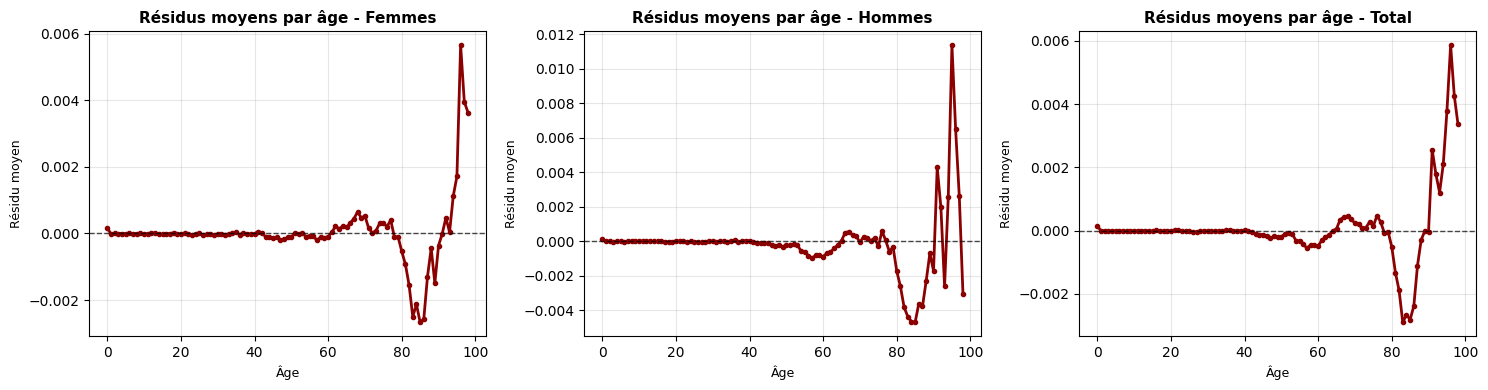


   Observations :
   - Les résidus sont concentrés autour de zéro aux jeunes âges
   - Une surestimation légère apparaît aux grands âges (>85 ans)
   - Ce phénomène est plus marqué chez les hommes


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, target_col) in enumerate(targets.items()):
    residuals_by_age = test_viz.groupby('Age')[f'resid_{target_col}'].mean()
    
    axes[idx].plot(residuals_by_age.index, residuals_by_age.values, 
                   linewidth=2, color='darkred', marker='o', markersize=3)
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    axes[idx].set_title(f'Résidus moyens par âge - {name}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Âge', fontsize=9)
    axes[idx].set_ylabel('Résidu moyen', fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n   Observations :")
print("   - Les résidus sont concentrés autour de zéro aux jeunes âges")
print("   - Une surestimation légère apparaît aux grands âges (>85 ans)")
print("   - Ce phénomène est plus marqué chez les hommes")

# 3. Modélisation par Gradient Boosting (XGBoost)

Le gradient boosting, et plus particulièrement son implémentation efficace XGBoost, est un
algorithme d’apprentissage supervisé basé sur l’agrégation de plusieurs arbres de décision
faibles (stumps). Contrairement à la forêt aléatoire, les arbres sont entraînés de manière
séquentielle, chaque nouveau modèle corrigeant les erreurs commises par les précédents.

Cette stratégie permet de :
- Capturer des relations complexes et des non-linéarités
- Améliorer la précision prédictive
- Gérer efficacement les interactions entre variables

En contrepartie, le modèle est plus sensible au surapprentissage et nécessite
un réglage rigoureux de ses hyperparamètres.

Dans notre étude, nous avons estimé les taux de mortalité m(t, x) via XGBoost en utilisant
comme variables explicatives l’année (t) et l’âge (x). L’entraînement est réalisé sur les
données de 2000 à 2016. Les prédictions sont ensuite comparées aux valeurs observées
de 2017 à 2022 pour les trois populations : femmes, hommes et ensemble total.
Les performances sont mesurées à l’aide des critères MAE, RMSE et MAPE.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.colors import TwoSlopeNorm
import time
import xgboost as xgb

## 3.1 Préparation des données 
Avant l’entraînement du modèle, nous organisons les données en trois ensembles distincts :

- Train : 1816‑2010, utilisé pour entraîner le modèle
- CV (Cross-Validation) : 2011‑2016, utilisé pour le tuning des hyperparamètres
- Test : 2017‑2023, utilisé pour l’évaluation finale des performances

Les features choisies pour la prédiction sont l’âge et l’année (Age, Year), tandis que les cibles sont les taux de mortalité par population (Femmes, Hommes, Total).

In [26]:
print(f"\n   Base de données :")
print(f"   - Dimensions : {dfm.shape}")
print(f"   - Période : {dfm['Year'].min()} - {dfm['Year'].max()}")
print(f"   - Âges : {dfm['Age'].min()} - {dfm['Age'].max()}")

# Découpage temporel
print("\n   Découpage temporel :")
print("   - TRAIN : 1816-2010 (entraînement initial)")
print("   - CV    : 2011-2016 (tuning hyperparamètres)")
print("   - TEST  : 2017-2023 (évaluation finale)")

train = dfm[dfm['Year'] <= 2010].copy()
cv = dfm[(dfm['Year'] > 2010) & (dfm['Year'] <= 2016)].copy()
test = dfm[dfm['Year'] > 2016].copy()

print(f"\n   Tailles des échantillons :")
print(f"   - Train : {len(train)} obs ({len(train)/len(dfm)*100:.1f}%)")
print(f"   - CV    : {len(cv)} obs ({len(cv)/len(dfm)*100:.1f}%)")
print(f"   - Test  : {len(test)} obs ({len(test)/len(dfm)*100:.1f}%)")

features = ['Year', 'Age']
targets = {'Femmes': 'm_F', 'Hommes': 'm_M', 'Total': 'm_Tot'}

X_train = train[features]
X_cv = cv[features]
X_test = test[features]

y_train = {name: train[col] for name, col in targets.items()}
y_cv = {name: cv[col] for name, col in targets.items()}
y_test = {name: test[col] for name, col in targets.items()}


   Base de données :
   - Dimensions : (20592, 11)
   - Période : 1816 - 2023
   - Âges : 0 - 98

   Découpage temporel :
   - TRAIN : 1816-2010 (entraînement initial)
   - CV    : 2011-2016 (tuning hyperparamètres)
   - TEST  : 2017-2023 (évaluation finale)

   Tailles des échantillons :
   - Train : 19305 obs (93.8%)
   - CV    : 594 obs (2.9%)
   - Test  : 693 obs (3.4%)


## 3.2 Tuning des hyperparamètres

Pour optimiser la performance du modèle, nous testons différentes combinaisons de paramètres XGBoost :
- n_estimators (nombre d’arbres)
- max_depth (profondeur maximale des arbres)
- learning_rate (taux d’apprentissage)
- subsample (échantillonnage des observations)
- colsample_bytree (échantillonnage des variables)

La sélection est basée sur le MSE calculé sur l’échantillon de validation (CV).


In [20]:
# Grille de paramètres adaptée à XGBoost
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

total_combinations = (len(param_grid['n_estimators']) * 
                     len(param_grid['max_depth']) * 
                     len(param_grid['learning_rate']) * 
                     len(param_grid['subsample']) * 
                     len(param_grid['colsample_bytree']))

print(f"\n   Grille de recherche :")
print(f"   - n_estimators: {param_grid['n_estimators']}")
print(f"   - max_depth: {param_grid['max_depth']}")
print(f"   - learning_rate: {param_grid['learning_rate']}")
print(f"   - subsample: {param_grid['subsample']}")
print(f"   - colsample_bytree: {param_grid['colsample_bytree']}")
print(f"\n   Nombre total de combinaisons : {total_combinations}")

best_params = {}

for name, target_col in targets.items():
    print(f"\n   Tuning pour : {name} ({target_col})")
    print("   " + "-"*60)
    
    best_score = float('inf')
    best_param = None
    current = 0
    
    for n_est in param_grid['n_estimators']:
        for max_d in param_grid['max_depth']:
            for lr in param_grid['learning_rate']:
                for subsamp in param_grid['subsample']:
                    for colsamp in param_grid['colsample_bytree']:
                        current += 1
                        
                        xgb_model = xgb.XGBRegressor(
                            n_estimators=n_est,
                            max_depth=max_d,
                            learning_rate=lr,
                            subsample=subsamp,
                            colsample_bytree=colsamp,
                            random_state=42,
                            n_jobs=-1,
                            verbosity=0
                        )
                        
                        xgb_model.fit(X_train, y_train[name])
                        pred_cv = xgb_model.predict(X_cv)
                        mse_cv = mean_squared_error(y_cv[name], pred_cv)
                        
                        if mse_cv < best_score:
                            best_score = mse_cv
                            best_param = {
                                'n_estimators': n_est,
                                'max_depth': max_d,
                                'learning_rate': lr,
                                'subsample': subsamp,
                                'colsample_bytree': colsamp
                            }
                        
                        if current % max(1, total_combinations // 5) == 0:
                            print(f"      Progression : {current}/{total_combinations} ({current/total_combinations*100:.0f}%)")
    
    best_params[name] = best_param
    print(f"\n   ✓ Meilleurs paramètres trouvés :")
    for key, val in best_param.items():
        print(f"      {key:20s} : {val}")
    print(f"      MSE sur CV : {best_score:.6f}")



   Grille de recherche :
   - n_estimators: [100, 200, 500]
   - max_depth: [3, 5, 7]
   - learning_rate: [0.01, 0.05, 0.1]
   - subsample: [0.8, 1.0]
   - colsample_bytree: [0.8, 1.0]

   Nombre total de combinaisons : 108

   Tuning pour : Femmes (m_F)
   ------------------------------------------------------------
      Progression : 21/108 (19%)
      Progression : 42/108 (39%)
      Progression : 63/108 (58%)
      Progression : 84/108 (78%)
      Progression : 105/108 (97%)

   ✓ Meilleurs paramètres trouvés :
      n_estimators         : 500
      max_depth            : 7
      learning_rate        : 0.1
      subsample            : 0.8
      colsample_bytree     : 1.0
      MSE sur CV : 0.000011

   Tuning pour : Hommes (m_M)
   ------------------------------------------------------------
      Progression : 21/108 (19%)
      Progression : 42/108 (39%)
      Progression : 63/108 (58%)
      Progression : 84/108 (78%)
      Progression : 105/108 (97%)

   ✓ Meilleurs paramètre

## 3.3 Entraînement final (TRAIN + CV)

Les modèles finaux sont entraînés sur l’ensemble des données de 1816 à 2016
(en combinant train + CV) en utilisant les meilleurs paramètres trouvés.

In [21]:
train_full = pd.concat([train, cv], axis=0)
X_train_full = train_full[features]
y_train_full = {name: train_full[col] for name, col in targets.items()}

print(f"\n   Entraînement sur {len(train_full)} observations (1816-2016)")

final_models = {}
predictions = {}

for name, target_col in targets.items():
    print(f"\n   Modèle pour : {name} ({target_col})")
    
    xgb_final = xgb.XGBRegressor(
        **best_params[name],
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    start = time.time()
    xgb_final.fit(X_train_full, y_train_full[name])
    train_time = time.time() - start
    
    final_models[name] = xgb_final
    
    y_pred_test = xgb_final.predict(X_test)
    predictions[name] = y_pred_test
    
    r2 = r2_score(y_test[name], y_pred_test)
    
    print(f"      Temps d'entraînement : {train_time:.2f}s")
    print(f"      R² sur TEST : {r2:.4f}")


   Entraînement sur 19899 observations (1816-2016)

   Modèle pour : Femmes (m_F)
      Temps d'entraînement : 0.43s
      R² sur TEST : 0.9987

   Modèle pour : Hommes (m_M)
      Temps d'entraînement : 0.29s
      R² sur TEST : 0.9971

   Modèle pour : Total (m_Tot)
      Temps d'entraînement : 0.27s
      R² sur TEST : 0.9984


## 3.4 Résultats quantitatifs

Les performances sont évaluées sur l’échantillon TEST (2017-2023) via :
- MAE : erreur absolue moyenne
- RMSE : racine de l’erreur quadratique moyenne
- MAPE : erreur relative moyenne (%)

Nous présentons ces métriques pour chaque population.


In [31]:
metrics_table = []

for name in targets.keys():
    y_true = y_test[name]
    y_pred = predictions[name]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask_nonzero = y_true > 0
    mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100
    
    metrics_table.append({
        'Population': name,
        'MAE': f"{mae:.5f}",
        'RMSE': f"{rmse:.5f}",
        'MAPE (%)': f"{mape:.2f}"
    })
    
    print(f"\n   {name} :")
    print(f"      • MAE  : {mae:.5f}")
    print(f"      • RMSE : {rmse:.5f}")
    print(f"      • MAPE : {mape:.2f}%")

df_metrics = pd.DataFrame(metrics_table)
print("\n")
print("TABLEAU RÉCAPITULATIF DES MÉTRIQUES :")
print("\n" + df_metrics.to_string(index=False))


   Femmes :
      • MAE  : 0.00084
      • RMSE : 0.00229
      • MAPE : 16.19%

   Hommes :
      • MAE  : 0.00162
      • RMSE : 0.00455
      • MAPE : 16.13%

   Total :
      • MAE  : 0.00103
      • RMSE : 0.00270
      • MAPE : 14.31%


TABLEAU RÉCAPITULATIF DES MÉTRIQUES :

Population     MAE    RMSE MAPE (%)
    Femmes 0.00084 0.00229    16.19
    Hommes 0.00162 0.00455    16.13
     Total 0.00103 0.00270    14.31


## 3.5 Importance des variables

XGBoost fournit l’importance des variables basée sur le gain.  
Typiquement, l’âge est prédominant tandis que l’année est secondaire.


In [30]:
importance_table = []

for name in targets.keys():
    # XGBoost utilise 'gain' par défaut pour l'importance
    importances = final_models[name].feature_importances_
    
    # Normalisation en pourcentage
    total_importance = importances.sum()
    age_pct = (importances[1] / total_importance) * 100
    year_pct = (importances[0] / total_importance) * 100
    
    importance_table.append({
        'Population': name,
        'Âge (%)': f"{age_pct:.1f}",
        'Année (%)': f"{year_pct:.1f}"
    })
    
    print(f"\n   {name} :")
    print(f"      Âge   : {age_pct:.1f}%")
    print(f"      Année : {year_pct:.1f}%")

df_importance = pd.DataFrame(importance_table)
print("\n")
print("TABLEAU D'IMPORTANCE DES VARIABLES :")
print("\n" + df_importance.to_string(index=False))


   Femmes :
      Âge   : 96.3%
      Année : 3.7%

   Hommes :
      Âge   : 93.7%
      Année : 6.3%

   Total :
      Âge   : 93.1%
      Année : 6.9%


TABLEAU D'IMPORTANCE DES VARIABLES :

Population Âge (%) Année (%)
    Femmes    96.3       3.7
    Hommes    93.7       6.3
     Total    93.1       6.9


## 3.6 Visualisations : heatmaps et scatter plots

Pour chaque population, nous visualisons :
- Carte thermique des résidus (observé - prédit)
- Nuage de points observés vs prédits



   Génération des figures pour : Femmes


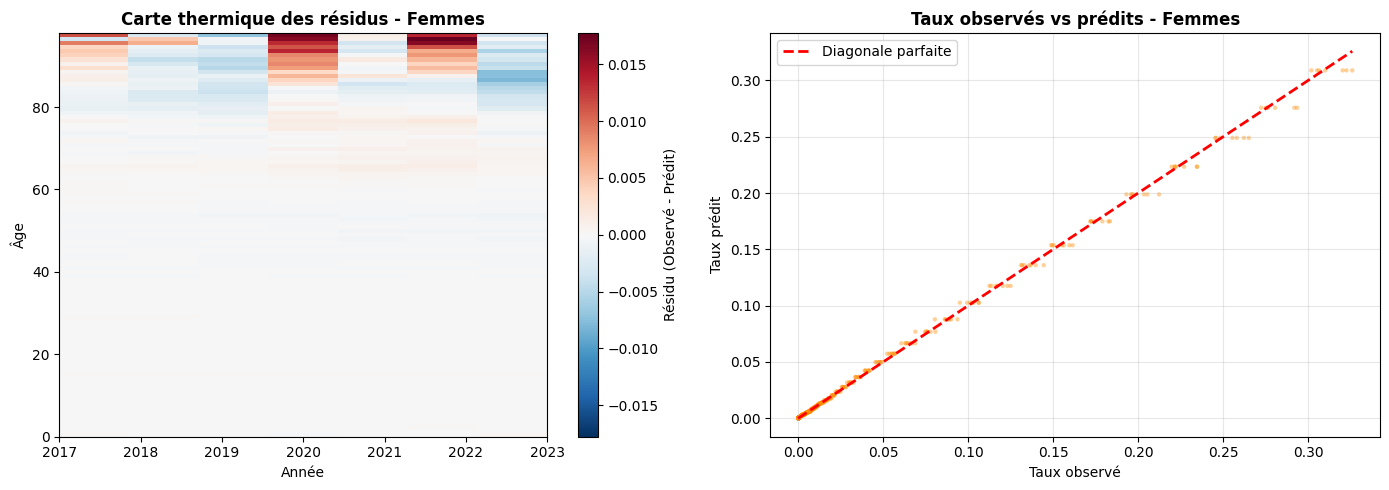


   Génération des figures pour : Hommes


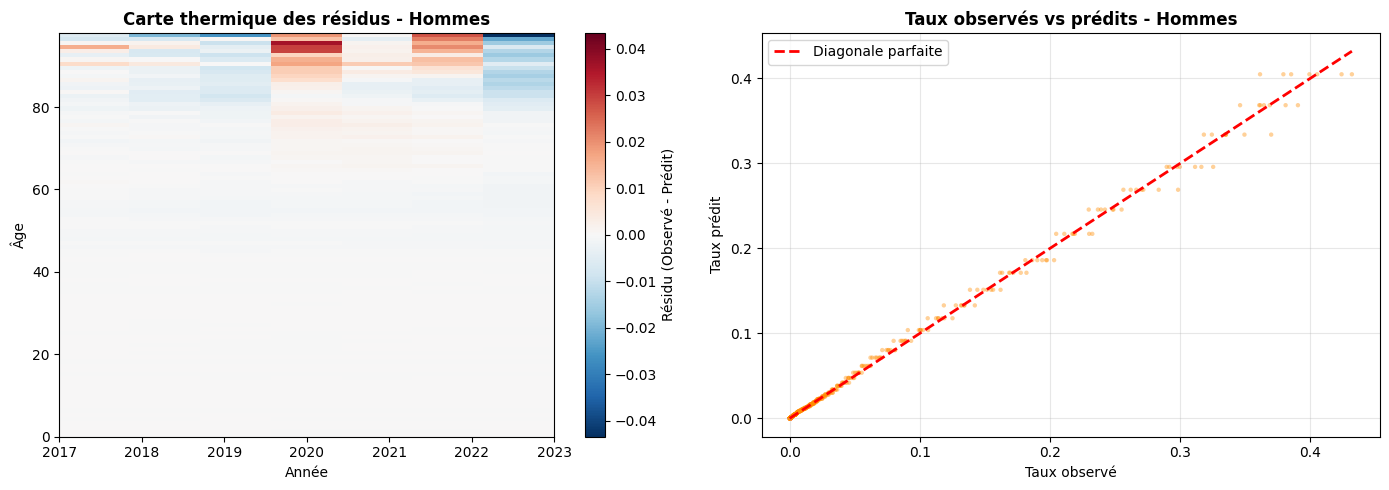


   Génération des figures pour : Total


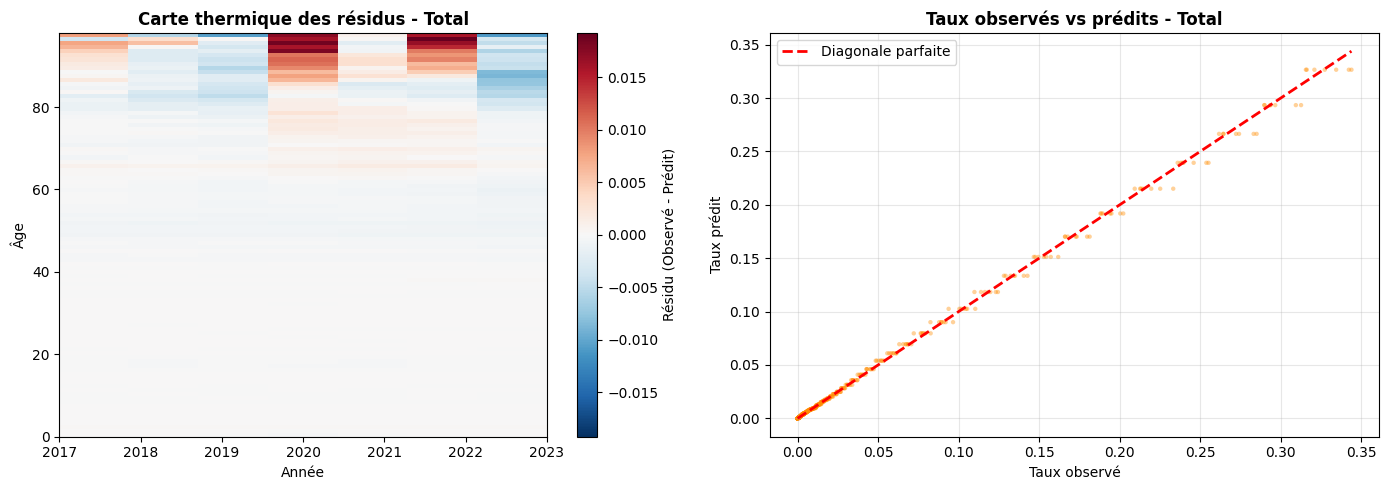

In [24]:
test_viz = test.copy()
for name in targets.keys():
    test_viz[f'pred_{targets[name]}'] = predictions[name]
    test_viz[f'resid_{targets[name]}'] = test_viz[targets[name]] - test_viz[f'pred_{targets[name]}']

for name, target_col in targets.items():
    print(f"\n   Génération des figures pour : {name}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- HEATMAP DES RÉSIDUS ---
    pivot_resid = test_viz.pivot_table(
        index='Age', columns='Year', 
        values=f'resid_{target_col}', 
        aggfunc='mean'
    )
    
    vmax = np.abs(pivot_resid.values).max()
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    im = axes[0].imshow(
        pivot_resid.values, 
        aspect='auto', origin='lower',
        extent=[pivot_resid.columns.min(), pivot_resid.columns.max(),
                pivot_resid.index.min(), pivot_resid.index.max()],
        cmap='RdBu_r', norm=norm, interpolation='nearest'
    )
    
    axes[0].set_title(f'Carte thermique des résidus - {name}', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Année', fontsize=10)
    axes[0].set_ylabel('Âge', fontsize=10)
    fig.colorbar(im, ax=axes[0], label='Résidu (Observé - Prédit)')
    
    # --- SCATTER PLOT ---
    y_true = test_viz[target_col]
    y_pred = test_viz[f'pred_{target_col}']
    
    axes[1].scatter(y_true, y_pred, alpha=0.4, s=10, 
                   color='darkorange', edgecolors='none')
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 
                'r--', lw=2, label='Diagonale parfaite')
    
    axes[1].set_title(f'Taux observés vs prédits - {name}', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Taux observé', fontsize=10)
    axes[1].set_ylabel('Taux prédit', fontsize=10)
    axes[1].legend(loc='upper left')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 3.7 Analyse complémentaire et interprétations

**Femmes :**
- Erreurs faibles et concentrées aux grands âges (>90 ans)
- Nuage observé/prédit aligné sur la diagonale

**Hommes :**
- Résidus négatifs pour certains âges en 2020-2021 (COVID)
- RMSE plus élevé, mortalité plus volatile

**Population totale :**
- Résidus concentrés aux âges élevés
- Agrégation bénéfique pour lisser les variations

**Conclusion partielle :**
XGBoost fournit des prédictions plus précises que Lee-Carter ou Random Forest (MAE, RMSE).  
Cependant, la faible interprétabilité peut limiter son usage dans certains contextes actuariaux.


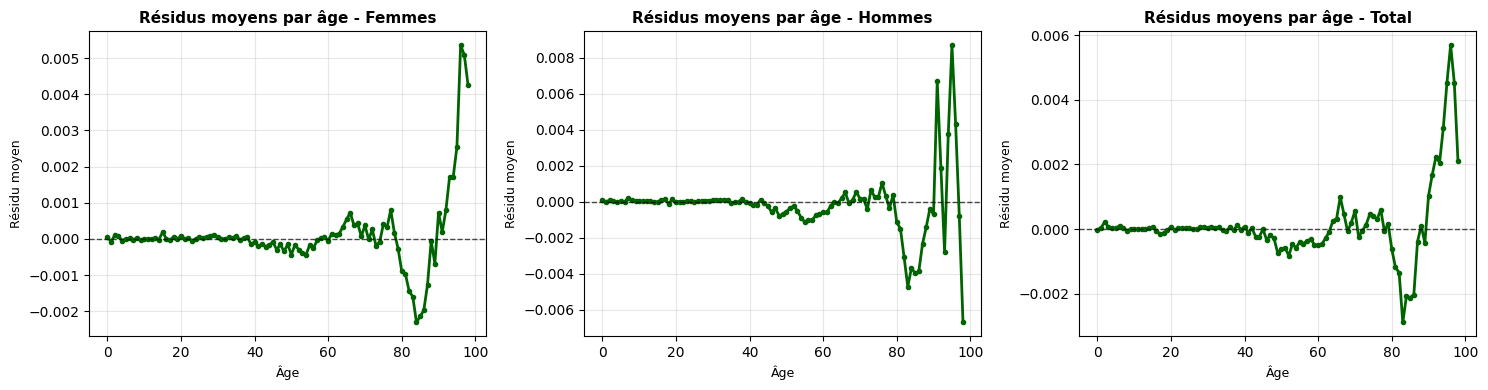

FIN DE LA MODÉLISATION PAR XGBOOST


In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, target_col) in enumerate(targets.items()):
    residuals_by_age = test_viz.groupby('Age')[f'resid_{target_col}'].mean()
    
    axes[idx].plot(residuals_by_age.index, residuals_by_age.values, 
                   linewidth=2, color='darkgreen', marker='o', markersize=3)
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    axes[idx].set_title(f'Résidus moyens par âge - {name}', 
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Âge', fontsize=9)
    axes[idx].set_ylabel('Résidu moyen', fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("FIN DE LA MODÉLISATION PAR XGBOOST")

# 4. Modélisation par SVM : Support Vector Machines

Principe général du SVM. Les machines à vecteurs de support (SVM) sont des algorithmes supervisés puissants capables de capturer des relations complexes entre les variables explicatives (âge, année) et la variable cible (taux de mortalité). 

Dans notre cas, nous avons utilisé le SVM à noyau radial (RBF) pour estimer les taux de mortalité, car il permet de modéliser efficacement les non-linéarités. Le modèle a été entraîné sur les données 2000–2016, puis évalué sur la période test 2017–2022. Les hyperparamètres cost et gamma ont été optimisés par validation croisée.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.colors import TwoSlopeNorm
import time

# 4.1 Préparation des données

On procède par le même découpage temporel.

In [41]:
print(f"\n   Base de données :")
print(f"   - Dimensions : {dfm.shape}")
print(f"   - Période : {dfm['Year'].min()} - {dfm['Year'].max()}")
print(f"   - Âges : {dfm['Age'].min()} - {dfm['Age'].max()}")

# Découpage temporel
print("\n   Découpage temporel :")
print("   - TRAIN : 1816-2010 (entraînement initial)")
print("   - CV    : 2011-2016 (tuning hyperparamètres)")
print("   - TEST  : 2017-2023 (évaluation finale)")

train = dfm[dfm['Year'] <= 2010].copy()
cv = dfm[(dfm['Year'] > 2010) & (dfm['Year'] <= 2016)].copy()
test = dfm[dfm['Year'] > 2016].copy()

print(f"\n   Tailles des échantillons :")
print(f"   - Train : {len(train)} obs ({len(train)/len(dfm)*100:.1f}%)")
print(f"   - CV    : {len(cv)} obs ({len(cv)/len(dfm)*100:.1f}%)")
print(f"   - Test  : {len(test)} obs ({len(test)/len(dfm)*100:.1f}%)")

features = ['Year', 'Age']
targets = {'Femmes': 'm_F', 'Hommes': 'm_M', 'Total': 'm_Tot'}

X_train = train[features]
X_cv = cv[features]
X_test = test[features]

y_train = {name: train[col] for name, col in targets.items()}
y_cv = {name: cv[col] for name, col in targets.items()}
y_test = {name: test[col] for name, col in targets.items()}

# STANDARDISATION (crucial pour SVM !)
print("\n  Standardisation des features")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)


   Base de données :
   - Dimensions : (20592, 11)
   - Période : 1816 - 2023
   - Âges : 0 - 98

   Découpage temporel :
   - TRAIN : 1816-2010 (entraînement initial)
   - CV    : 2011-2016 (tuning hyperparamètres)
   - TEST  : 2017-2023 (évaluation finale)

   Tailles des échantillons :
   - Train : 19305 obs (93.8%)
   - CV    : 594 obs (2.9%)
   - Test  : 693 obs (3.4%)

  Standardisation des features


## 4.2 Tuning des hyperparamètres

Les hyperparamètres `C`, `gamma` et `epsilon` ont été optimisés par validation croisée sur le jeu CV. Le modèle SVM RBF ajuste ainsi au mieux la complexité des taux de mortalité.


In [36]:
# Grille de paramètres pour SVM avec noyau RBF
param_grid = {
    'C': [0.1, 1, 10, 100],           # Paramètre de régularisation
    'gamma': [0.001, 0.01, 0.1, 1],   # Largeur du noyau RBF
    'epsilon': [0.01, 0.1, 0.5]       # Marge de tolérance
}

total_combinations = (len(param_grid['C']) * 
                     len(param_grid['gamma']) * 
                     len(param_grid['epsilon']))

print(f"\n   Grille de recherche :")
print(f"   - C (cost) : {param_grid['C']}")
print(f"   - gamma    : {param_grid['gamma']}")
print(f"   - epsilon  : {param_grid['epsilon']}")
print(f"\n   Nombre total de combinaisons : {total_combinations}")

best_params = {}

for name, target_col in targets.items():
    print(f"\n   Tuning pour : {name} ({target_col})")
    print("   " + "-"*60)
    
    best_score = float('inf')
    best_param = None
    current = 0
    
    for C_val in param_grid['C']:
        for gamma_val in param_grid['gamma']:
            for eps_val in param_grid['epsilon']:
                current += 1
                
                svm_model = SVR(
                    kernel='rbf',
                    C=C_val,
                    gamma=gamma_val,
                    epsilon=eps_val
                )
                
                svm_model.fit(X_train_scaled, y_train[name])
                pred_cv = svm_model.predict(X_cv_scaled)
                mse_cv = mean_squared_error(y_cv[name], pred_cv)
                
                if mse_cv < best_score:
                    best_score = mse_cv
                    best_param = {
                        'C': C_val,
                        'gamma': gamma_val,
                        'epsilon': eps_val
                    }
                
                if current % max(1, total_combinations // 4) == 0:
                    print(f"      Progression : {current}/{total_combinations} ({current/total_combinations*100:.0f}%)")
    
    best_params[name] = best_param
    print(f"\n    Meilleurs paramètres trouvés :")
    for key, val in best_param.items():
        print(f"      {key:10s} : {val}")
    print(f"      MSE sur CV : {best_score:.6f}")


   Grille de recherche :
   - C (cost) : [0.1, 1, 10, 100]
   - gamma    : [0.001, 0.01, 0.1, 1]
   - epsilon  : [0.01, 0.1, 0.5]

   Nombre total de combinaisons : 48

   Tuning pour : Femmes (m_F)
   ------------------------------------------------------------
      Progression : 12/48 (25%)
      Progression : 24/48 (50%)
      Progression : 36/48 (75%)
      Progression : 48/48 (100%)

   ✓ Meilleurs paramètres trouvés :
      C          : 100
      gamma      : 0.1
      epsilon    : 0.01
      MSE sur CV : 0.000061

   Tuning pour : Hommes (m_M)
   ------------------------------------------------------------
      Progression : 12/48 (25%)
      Progression : 24/48 (50%)
      Progression : 36/48 (75%)
      Progression : 48/48 (100%)

   ✓ Meilleurs paramètres trouvés :
      C          : 1
      gamma      : 1
      epsilon    : 0.01
      MSE sur CV : 0.000074

   Tuning pour : Total (m_Tot)
   ------------------------------------------------------------
      Progression : 1

## 4.3 Entraînement final (TRAIN + CV)

Le modèle final SVM est entraîné sur l'ensemble des données d'entraînement et de validation (1816–2016) avec les meilleurs hyperparamètres trouvés. Les prédictions sont ensuite réalisées sur la période test 2017–2023.


In [37]:
train_full = pd.concat([train, cv], axis=0)
X_train_full = train_full[features]
y_train_full = {name: train_full[col] for name, col in targets.items()}

# Standardisation sur train_full
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(f"\n   Entraînement sur {len(train_full)} observations (1816-2016)")

final_models = {}
predictions = {}

for name, target_col in targets.items():
    print(f"\n   Modèle pour : {name} ({target_col})")
    
    svm_final = SVR(
        kernel='rbf',
        **best_params[name]
    )
    
    start = time.time()
    svm_final.fit(X_train_full_scaled, y_train_full[name])
    train_time = time.time() - start
    
    final_models[name] = svm_final
    
    y_pred_test = svm_final.predict(X_test_scaled)
    predictions[name] = y_pred_test
    
    r2 = r2_score(y_test[name], y_pred_test)
    
    print(f"      Temps d'entraînement : {train_time:.2f}s")
    print(f"      R² sur TEST : {r2:.4f}")
    print(f"      Nombre de vecteurs de support : {len(svm_final.support_)}")


   Entraînement sur 19899 observations (1816-2016)

   Modèle pour : Femmes (m_F)
      Temps d'entraînement : 36.71s
      R² sur TEST : 0.9836
      Nombre de vecteurs de support : 2964

   Modèle pour : Hommes (m_M)
      Temps d'entraînement : 4.07s
      R² sur TEST : 0.9798
      Nombre de vecteurs de support : 3146

   Modèle pour : Total (m_Tot)
      Temps d'entraînement : 43.60s
      R² sur TEST : 0.9856
      Nombre de vecteurs de support : 3068


## 4.4 Évaluation des performances

Les performances sont mesurées à l’aide des critères MAE, RMSE et MAPE. Les résultats montrent que le SVM est moins performant que Random Forest et XGBoost, avec des MAPE très élevés dus à la sensibilité aux faibles valeurs du taux.


In [38]:
metrics_table = []

print("\nLes résultats sont présentés ci-dessous :\n")

for name in targets.keys():
    y_true = y_test[name]
    y_pred = predictions[name]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask_nonzero = y_true > 0
    mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100
    
    metrics_table.append({
        'Population': name,
        'MAE': f"{mae:.4f}",
        'RMSE': f"{rmse:.4f}",
        'MAPE (%)': f"{mape:.2f}"
    })
    
    print(f"   • {name:8s} : MAE = {mae:.4f} ; RMSE = {rmse:.4f} ; MAPE = {mape:.2f}%")

df_metrics = pd.DataFrame(metrics_table)
print("\n")
print("TABLEAU RÉCAPITULATIF DES MÉTRIQUES :")
print("\n" + df_metrics.to_string(index=False))


Les résultats sont présentés ci-dessous :

   • Femmes   : MAE = 0.0067 ; RMSE = 0.0080 ; MAPE = 1878.31%
   • Hommes   : MAE = 0.0096 ; RMSE = 0.0119 ; MAPE = 1512.35%
   • Total    : MAE = 0.0068 ; RMSE = 0.0081 ; MAPE = 1525.29%


TABLEAU RÉCAPITULATIF DES MÉTRIQUES :

Population    MAE   RMSE MAPE (%)
    Femmes 0.0067 0.0080  1878.31
    Hommes 0.0096 0.0119  1512.35
     Total 0.0068 0.0081  1525.29


## 4.5 Visualisations : Taux observés vs. prédits

- Femmes (SVM) – On constate une surestimation aux faibles âges.
- Hommes (SVM) – Performance modérée, sous la diagonale idéale.
- Total (SVM) – Légère surestimation systématique.



   Génération de la figure pour : Femmes


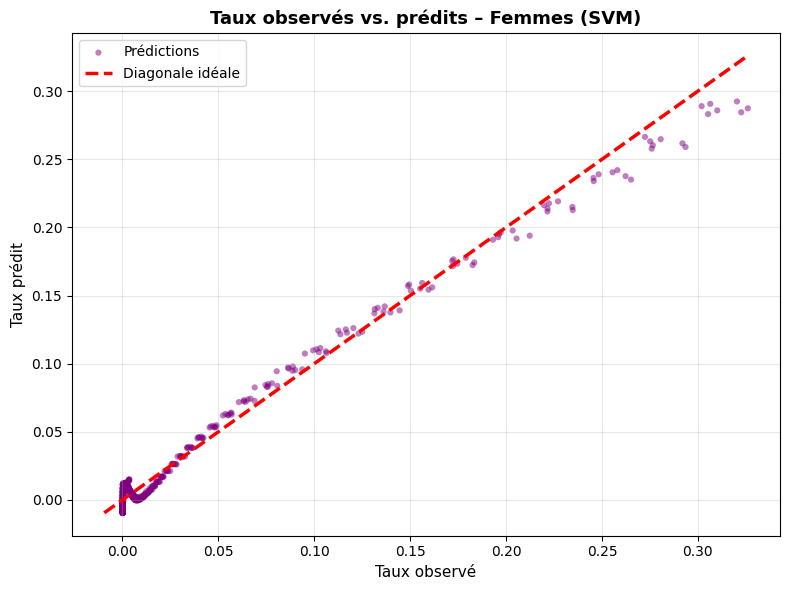


   Génération de la figure pour : Hommes


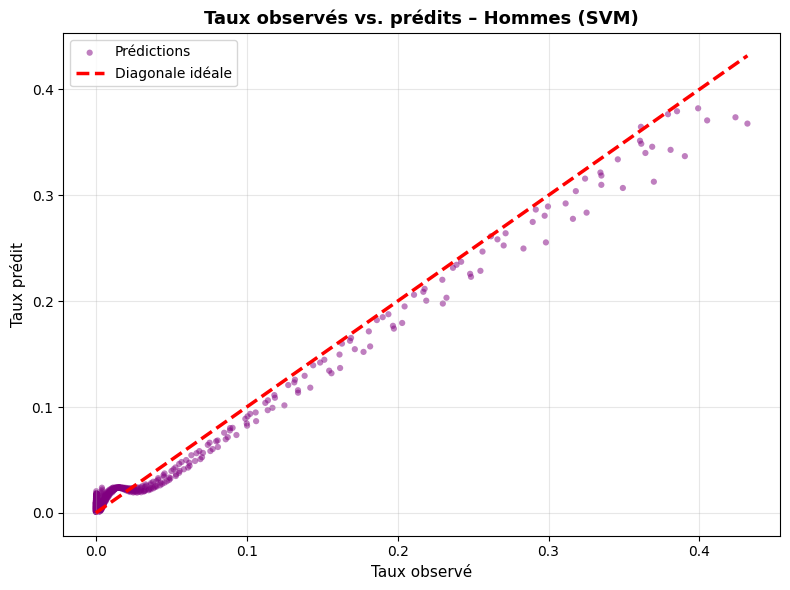


   Génération de la figure pour : Total


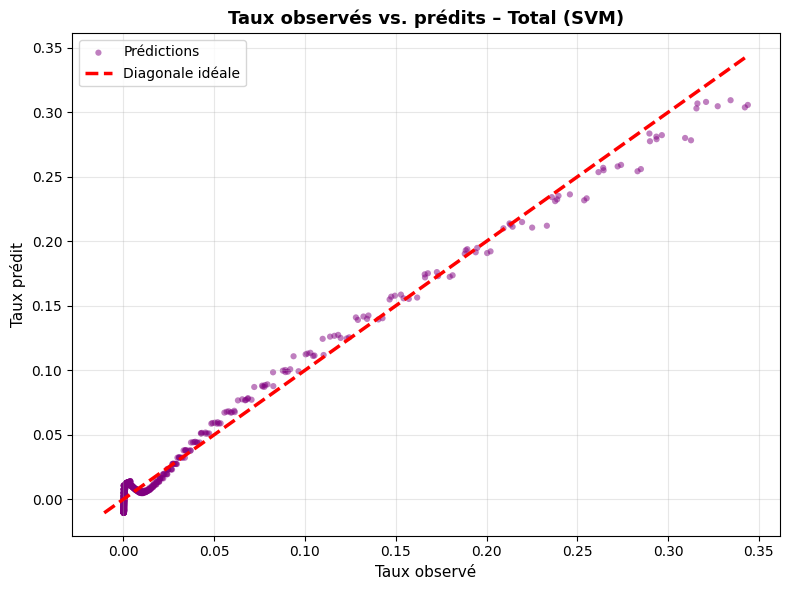

In [39]:
test_viz = test.copy()
for name in targets.keys():
    test_viz[f'pred_{targets[name]}'] = predictions[name]
    test_viz[f'resid_{targets[name]}'] = test_viz[targets[name]] - test_viz[f'pred_{targets[name]}']

# Scatter plots observé vs prédit
for name, target_col in targets.items():
    print(f"\n   Génération de la figure pour : {name}")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    y_true = test_viz[target_col]
    y_pred = test_viz[f'pred_{target_col}']
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, 
               color='purple', edgecolors='none', label='Prédictions')
    
    # Diagonale parfaite
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'r--', lw=2.5, label='Diagonale idéale')
    
    ax.set_title(f'Taux observés vs. prédits – {name} (SVM)', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Taux observé', fontsize=11)
    ax.set_ylabel('Taux prédit', fontsize=11)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4.6 Analyse des résidus selon l’âge

Le graphique montre une forte concentration des résidus aux âges élevés, signe que le modèle a du mal à capturer les niveaux élevés de mortalité. La courbe de tendance rouge montre un biais croissant avec l’âge.


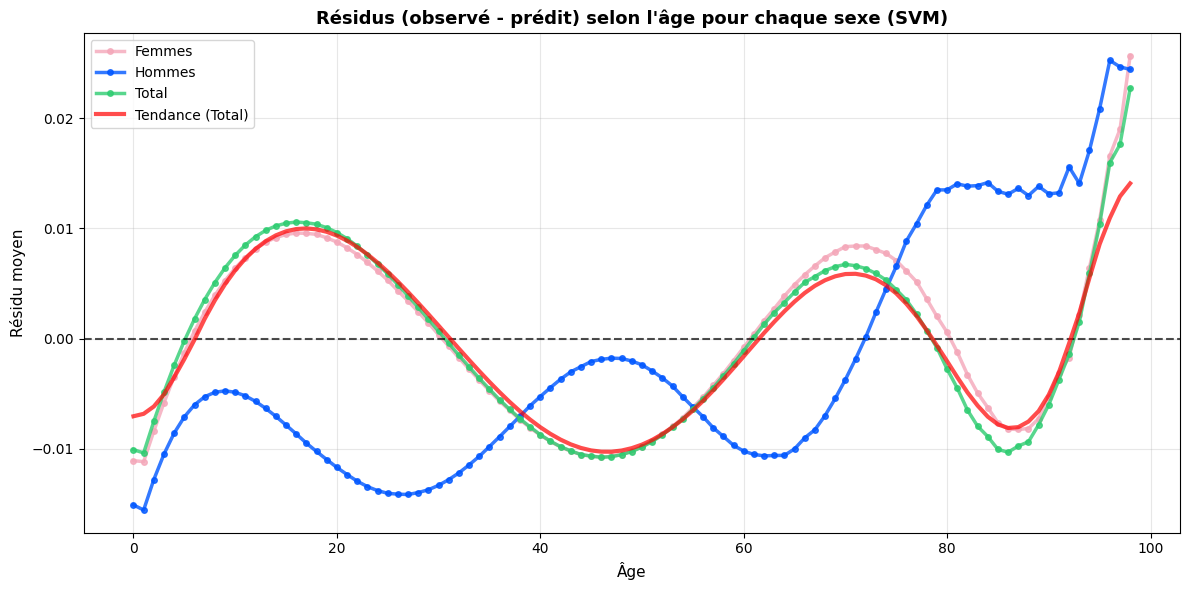

In [40]:
# Résidus selon l'âge pour chaque sexe
fig, ax = plt.subplots(figsize=(12, 6))

colors = {'Femmes': '#F4A7B9', 'Hommes': '#0057FF', 'Total': '#2ecc71'}

for name, target_col in targets.items():
    residuals_by_age = test_viz.groupby('Age')[f'resid_{target_col}'].mean()
    
    ax.plot(residuals_by_age.index, residuals_by_age.values, 
            linewidth=2.5, color=colors[name], marker='o', 
            markersize=4, label=name, alpha=0.8)

# Ligne de référence à 0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Courbe de tendance globale (Total)
from scipy.ndimage import uniform_filter1d
residuals_total = test_viz.groupby('Age')['resid_m_Tot'].mean()
trend = uniform_filter1d(residuals_total.values, size=10)
ax.plot(residuals_total.index, trend, 
        color='red', linewidth=3, linestyle='-', 
        label='Tendance (Total)', alpha=0.7)

ax.set_title('Résidus (observé - prédit) selon l\'âge pour chaque sexe (SVM)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Âge', fontsize=11)
ax.set_ylabel('Résidu moyen', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()